In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 


from sklearn import metrics
import nltk
import os
from nltk.corpus import stopwords
from textblob import Word
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mandi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [93]:
df = pd.read_csv("Outlook_mail.csv")
df

,Subject,Body,Categories,Importance,Sensitivity
0,Welcome back email for Term 3 Freshmore,"Dear Cohort 2 Students,\n\n \n\nWelcome back f...",NaN,Normal,Normal
1,SC06 Group 8 HOA1 Submission,"Hi prof,\r\n\r\n Attached is ou...",NaN,Normal,Normal
2,🥋SUTD KARATE INTRO SESSION!!🥋,Hiya!\n\nReady to get a full body workout?!? P...,NaN,Normal,Normal
3,Register Now - SSIA Summit 2021 (30 Sept 2021),"Dear SUTD Community,\r\n\r\n \r\n\r\nYou are c...",NaN,Normal,Normal
4,HASS Minors Info Session,HAPPENING TODAY!\r\n\r\n \r\n\r\nDear Freshmor...,NaN,Normal,Normal
...,...,...,...,...,...
524,Natalie mentioned 10.020 Data Driven World (Fa...,External Email – Do not click on any links or ...,NaN,Normal,Normal
525,#ProjectYOU 2021 - Bold@Work Juraseek Playgrou...,\r\nHello there! \r\n\r\n \r\n\r\n \r\n\r\n ...,NaN,Normal,Normal
526,RE: [Update] Postponement of Lazarus Island Di...,"Hi all, \r\n\r\n \r\n\r\nIn view of the latest...",NaN,Normal,Normal
527,[Update] Athletics Introduction Session,"Dear Freshmore and SUTDents,\r\n\r\n\r\n\r\n\r...",NaN,Normal,Normal


In [94]:
df['Body'] = df['Body'].apply(lambda x: x.lower())
punctuations = '\.\!\?'
df = (df.drop('Body',axis=1).merge(df.Body.str.extractall(f'(?P<Body>[^{punctuations}]+[{punctuations}])\s?').reset_index('match'),left_index=True, right_index=True, how='left'))
df['Body'] = df['Body'].str.replace("[^\w\s<>]", "")
df = df.replace(r'[^0-9a-zA-Z ]', '', regex=True).replace("'", '')
#print(type(df['Body']))
#df.applymap(type)
df['Body'] = df['Body'].astype(str)
df['Body'] = df['Body'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) # change similar terms to the same
stop = stopwords.words("english") #remove useless words
df['Body'] = df['Body'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

df

,Subject,Categories,Importance,Sensitivity,match,Body
0,Welcome back email for Term 3 Freshmore,NaN,Normal,Normal,0.0,dear cohort 2 student welcome back vacation
0,Welcome back email for Term 3 Freshmore,NaN,Normal,Normal,1.0,hope good 4 month break
0,Welcome back email for Term 3 Freshmore,NaN,Normal,Normal,2.0,many upcoming activity event cdc
0,Welcome back email for Term 3 Freshmore,NaN,Normal,Normal,3.0,head
0,Welcome back email for Term 3 Freshmore,NaN,Normal,Normal,4.0,1 upop module linkeding upthis 5th upop module...
...,...,...,...,...,...,...
528,Summary of coverage Highlights of SUTD,NaN,NaN,NaN,237.0,mr chan also announced new ssrc graduate resea...
528,Summary of coverage Highlights of SUTD,NaN,NaN,NaN,238.0,initiative offer boost singaporean made move e...
528,Summary of coverage Highlights of SUTD,NaN,NaN,NaN,239.0,fellowship provide grant 10000 phd student 200...
528,Summary of coverage Highlights of SUTD,NaN,NaN,NaN,240.0,application scheme open next year


In [95]:
#vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)

# max_df removes words that appears more than _%
# min_df removes words that appears less than _

vect = TfidfVectorizer(ngram_range=(1,3),
                     min_df = 100,
                     max_df = 0.4,
                     token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*[a-z]+\\w*\\b')
X = vect.fit_transform(df['Body'].values.astype('U'))

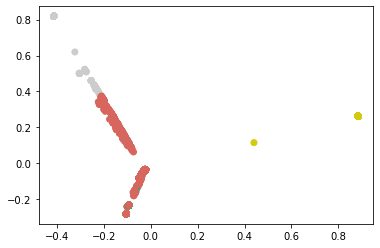

In [96]:
# Kmeans
from sklearn.cluster import KMeans
n_clusters = 5
clf = KMeans(n_clusters=n_clusters, max_iter=300, init='k-means++', n_init=1)
labels = clf.fit_predict(X)

# For larger datasets use mini-batch KMeans, so we dont have to read all data into memory.
# batch_size = 500
# clf = MiniBatchKMeans(n_clusters=n_clusters, init_size=1000, batch_size=batch_size, max_iter=100)  
# clf.fit(X)

# Let's plot this with matplotlib to visualize it.
# First we need to make 2D coordinates from the sparse matrix.
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

# Lets plot it again, but this time we add some color to it.
# This array needs to be at least the length of the n_clusters.
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]
# Plot clusters
plt.scatter(coords[:, 0], coords[:, 1], c=colors)





In [97]:
# top keywords in the emails

def top_tfidf_feats(row, features, top_n=20000):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

features = vect.get_feature_names()
print(top_feats_in_doc(X, features, 1, 10))

       features  score
0          hope    1.0
1          zoom    0.0
2  httpssutdcsm    0.0
3    httpsapc01    0.0
4          help    0.0
5            ha    0.0
6         group    0.0
7      graduate    0.0
8        google    0.0
9           get    0.0


In [98]:
# top terms out of all the emails
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=20000):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

print(top_mean_feats(X, features, top_n=10))

            features     score
0                edu  0.079746
1               sutd  0.076675
2                com  0.061430
3         protection  0.059480
4            outlook  0.059419
5          safelinks  0.059348
6         httpsapc01  0.044332
7  urlhttps3a2f2fwww  0.016099
8                 sg  0.010776
9          instagram  0.010527


In [99]:
# extracts the top terms per cluster
features = vect.get_feature_names()
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=10):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids,    min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

top_feats_per_cluster(X, labels, features, min_tfidf=0.1, top_n=10)

[   features     score
 0      make  0.613449
 1       new  0.037519
 2  industry  0.037340
 3      join  0.035340
 4      time  0.031622
 5      come  0.030729
 6     learn  0.026820
 7      form  0.026460
 8   session  0.025907
 9     would  0.025862,
       features     score
 0   protection  0.999550
 1  application  0.000405
 2  information  0.000402
 3       google  0.000000
 4   httpsdrive  0.000000
 5   httpsapc01  0.000000
 6         hope  0.000000
 7         help  0.000000
 8           ha  0.000000
 9        group  0.000000,
             features     score
 0                com  0.078382
 1            outlook  0.075817
 2          safelinks  0.075725
 3         httpsapc01  0.056269
 4  urlhttps3a2f2fwww  0.020541
 5                 sg  0.013701
 6          instagram  0.013280
 7               team  0.013263
 8             office  0.013126
 9            student  0.012754,
      features     score
 0        sutd  0.992822
 1     student  0.002967
 2  httpsapc01  0.002593
 3   i

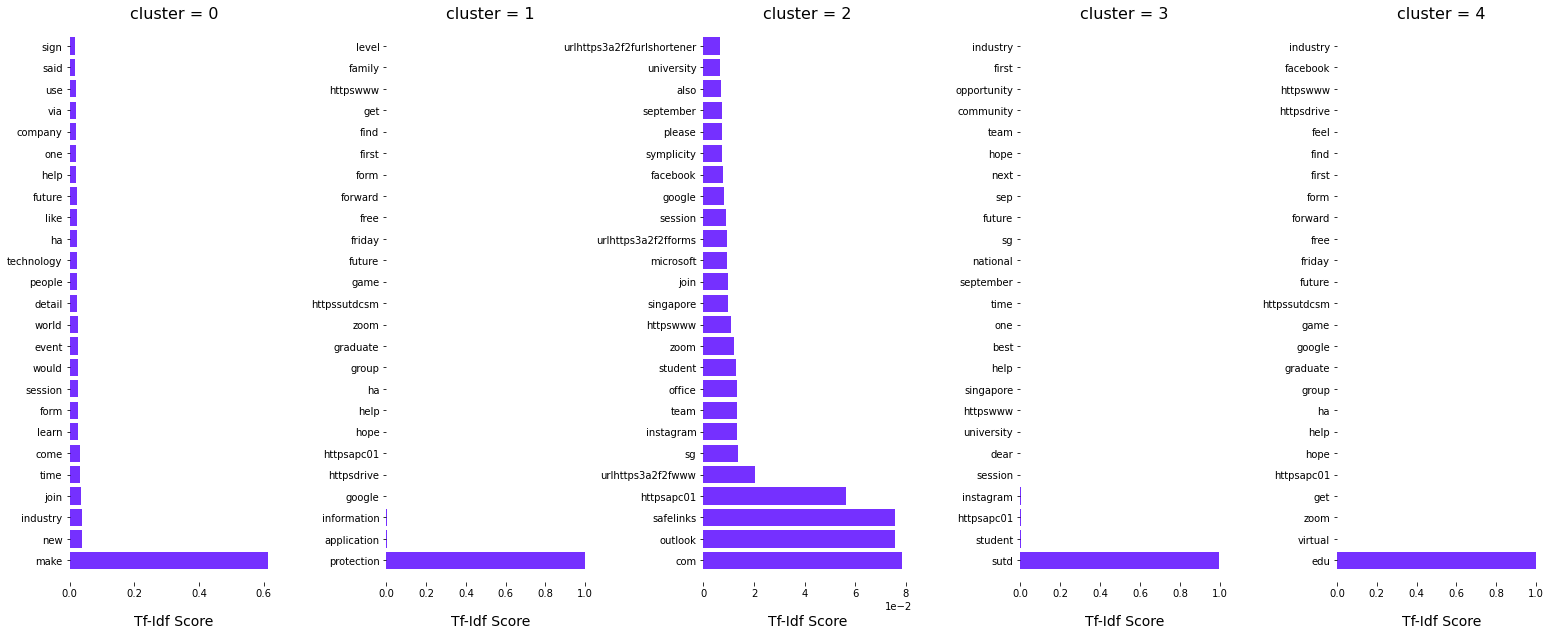

In [100]:
#Use this to print the top terms per cluster with matplotlib.

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(25, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()


plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))